## Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [27]:
import string
import os

import torch, torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as plt

from networks import CharRNNCell, CharLSTMLoop

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.


text = [sentence.lower() for sentence in text] # Your great code here
text = "".join(text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Tokens 

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
token_to_idx = {
    token: idx
    for idx, token in enumerate(tokens)
} # Your great code here

# dict <char>:<index>
idx_to_token = {
    idx: token
    for idx, token in enumerate(tokens)
} # Your great code here

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Preprocess Shakespeare

In [6]:
shakespeare_texts = text.split("\n\n")[::2]

In [7]:
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(shakespeare_texts, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True,
                                  shuffle=True, drop_last=True)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
def to_matrix(texts, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    """Casts a list of texts into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, texts))
    texts_ix = np.zeros([len(texts), max_len], dtype) + pad

    for i in range(len(texts)):
        line_ix = [token_to_idx[c] for c in texts[i]]
        texts_ix[i, :len(line_ix)] = line_ix[:max_len]
        
    if not batch_first:
        texts_ix = np.transpose(texts_ix)

    return texts_ix

In [9]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    probs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, p_next = char_rnn(x_t, hid_state)
        probs.append(p_next)
        
    return torch.stack(probs, dim=1)

In [10]:
def train_vanila_rnn(model, loader, criterion, opt):
    model.train()
    train_loss = []
    for batch in loader:
        batch_ix = to_matrix(batch, max_len=None)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        p_seq = rnn_loop(char_rnn, batch_ix)

        # compute loss
        predictions_p = p_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]
        loss = criterion(predictions_p.contiguous().view(-1, len(tokens)), 
                      actual_next_tokens.contiguous().view(-1))

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data)
        
    return np.mean(train_loss)

In [11]:
char_rnn = CharRNNCell(num_tokens=len(tokens), embedding_size=64, rnn_num_units=128)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

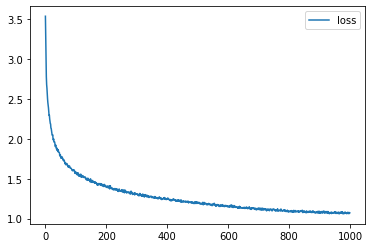

In [12]:
for i in range(1000):
    loss = train_vanila_rnn(char_rnn, train_dataloader, criterion, opt)
    
    history.append(loss)
    if (i+1)%10==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

In [13]:
def generate_sample_for_vanila_rnn(char_rnn, seed_phrase, max_length, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [14]:
temperatures = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5]
for temp in temperatures:
    print(f"Text for temperature = {temp}:")
    print(generate_sample_for_vanila_rnn(char_rnn, seed_phrase="  hello", max_length=400, temperature=temp))
    print("-----------------------------------")

Text for temperature = 0.1:
  hellose thee,
  and there thought thou lessing brink,
    but when i shall never doth live, that thee that shall will shall be the face should so grace to me, then thou mayst thou lease of my love, that thou mayst than thy self thou art the present made of deare
  when i now is the present more shart in my death enough to my sour, and thee all my self a torment that which thou thee shall still t
-----------------------------------
Text for temperature = 0.3:
  helloul that you lov'st the world a tormert.
    then in the warts i to the words the world alone, and for thee sweet be thy self i have to show the very some thy seen,
  which in their sweet seem seem doth bad which in the world summer may of youth,
  when thou art the sport,
  and in the world me then being are shall his some be this by the worth and prize of thy sing.
  if thou art single as 
-----------------------------------
Text for temperature = 0.5:
  hellose thee with the bost thou thee:
  

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [15]:
def train_lstm(model, loader, criterion, opt):
    model.train()
    train_loss = []
    for batch in loader:
        batch_ix = to_matrix(batch, max_len=None)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        state_h, state_c = model.initial_state(len(batch_ix))
        p_seq, (state_h, state_c) = model(batch_ix, (state_h, state_c))

        # compute loss
        predictions_p = p_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]
        loss = criterion(predictions_p.contiguous().view(-1, len(tokens)), 
                      actual_next_tokens.contiguous().view(-1))

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data)
        
    return np.mean(train_loss)

In [32]:
model = CharLSTMLoop(num_tokens=len(tokens), emb_size=64, rnn_num_units=256, num_layers=2)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
history = []

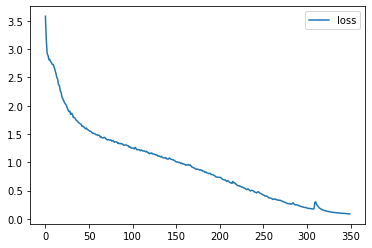

In [33]:
for i in range(350):
    loss = train_lstm(model, train_dataloader, criterion, opt)
    
    history.append(loss)
    if (i+1)%10==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        scheduler.step(np.mean(history))

In [34]:
def generate_sample_for_lstm(model, seed_phrase, max_length, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    state_h, state_c = model.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, (state_h, state_c) = model(x_sequence[:, i].reshape(-1, 1), (state_h, state_c))

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, (state_h, state_c) = model(x_sequence[:, -1].reshape(-1, 1), (state_h, state_c))
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next.flatten())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [35]:
for temp in temperatures:
    print(f"Text for temperature = {temp}:")
    print(generate_sample_for_lstm(model, seed_phrase="  hello", max_length=400, temperature=temp))
    print("-----------------------------------")

Text for temperature = 0.1:
  hello out as thy fair warerom of the shade,
  with time in him thought i call throu all in all,
  so day, and thou hast to wor have i seen,
  that do ninehe mausing what good thee bright,
  without all illare to live anoth prove,
  mad will comporan doth the pride of thine,
  that may is partil, rest in thee deeds,
  that my fair true lies weak shew-orn than the grey;
  lest themselves i shall e
-----------------------------------
Text for temperature = 0.3:
  hello will                                                                                                                                                                                                                                                                                                                                                                                                    
-----------------------------------
Text for temperature = 0.5:
  hello outwiar the self--if lain thine?
 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [36]:
PATH = "./lstm_Shakespeare"
torch.save(model.state_dict(), PATH)

In [39]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)